In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
pd.options.display.max_columns = None

X_train = pd.read_csv("train_values.csv")
y_train = pd.read_csv("train_labels.csv")

Using TensorFlow backend.


In [2]:
replace_dict = {
'msa_md': -1,
'state_code': -1,
'county_code': -1,
'occupancy': 3,
'preapproval': 3,
'applicant_ethnicity': [3, 4, 5],
"applicant_race": [6, 7, 8],
"applicant_sex": [3, 4, 5]
}
    
to_log = ["loan_amount", "applicant_income", "number_of_owner-occupied_units",
          "number_of_1_to_4_family_units", "minority_population"]

to_drop = ["row_id", "number_of_1_to_4_family_units",
           "occupancy", "preapproval", "county_code"]

num_cols = ["loan_amount", "applicant_income", "population", "minority_population_pct",
            "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
            "number_of_owner-occupied_units"]

cat_cols_few = ["loan_type", "property_type", "loan_purpose",
            "applicant_ethnicity", "applicant_race",
            "applicant_sex", "co_applicant"]

def prepare_data(df):
    
    df["co_applicant"] = df["co_applicant"].astype("int8")
    
    df.replace(replace_dict, np.nan, inplace = True)
    
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
        
    for col in cat_cols_few:
        df[col].fillna(df[col].mode()[0], inplace=True)
        
    df["minority_population"] = (df["minority_population_pct"] / 100) * (df["population"])
    df["tract_family_income"] = (df["tract_to_msa_md_income_pct"] / 100) * (df["ffiecmedian_family_income"])

    df[to_log] = df[to_log].applymap(math.log)
    
    to_drop.extend(["minority_population_pct", "population",
                    "ffiecmedian_family_income", "tract_to_msa_md_income_pct"])
    df.drop(to_drop, axis=1, inplace=True)
    
    df = pd.get_dummies(df, columns = cat_cols_few)
    
    return df

In [3]:
X_train = prepare_data(X_train)

ce_target = ce.TargetEncoder(cols = ["lender", "msa_md", "state_code"], smoothing = 5, return_df = True)
X_train = ce_target.fit_transform(X_train, y_train["accepted"])

X_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_amount                     500000 non-null  float64
 1   msa_md                          500000 non-null  float64
 2   state_code                      500000 non-null  float64
 3   applicant_income                500000 non-null  float64
 4   number_of_owner-occupied_units  500000 non-null  float64
 5   lender                          500000 non-null  float64
 6   minority_population             500000 non-null  float64
 7   tract_family_income             500000 non-null  float64
 8   loan_type_1                     500000 non-null  uint8  
 9   loan_type_2                     500000 non-null  uint8  
 10  loan_type_3                     500000 non-null  uint8  
 11  loan_type_4                     500000 non-null  uint8  
 12  property_type_1 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train.values, y_train["accepted"].values, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=29, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=200, verbose=1)

model.fit(X_train, y_train)
prediction = model.predict(X_test)

Epoch 1/20
350000/350000 [==============================] - 4s 10us/step - loss: 0.5760 - accuracy: 0.6985
Epoch 2/20
350000/350000 [==============================] - 4s 10us/step - loss: 0.5583 - accuracy: 0.7122
Epoch 3/20
350000/350000 [==============================] - 4s 10us/step - loss: 0.5552 - accuracy: 0.7139
Epoch 4/20
350000/350000 [==============================] - 4s 10us/step - loss: 0.5538 - accuracy: 0.7151
Epoch 5/20
350000/350000 [==============================] - 3s 10us/step - loss: 0.5533 - accuracy: 0.7152
Epoch 6/20
350000/350000 [==============================] - 4s 10us/step - loss: 0.5527 - accuracy: 0.7158
Epoch 7/20
350000/350000 [==============================] - 3s 10us/step - loss: 0.5523 - accuracy: 0.7159
Epoch 8/20
350000/350000 [==============================] - 3s 10us/step - loss: 0.5524 - accuracy: 0.7161
Epoch 9/20
350000/350000 [==============================] - 3s 10us/step - loss: 0.5521 - accuracy: 0.7164
Epoch 10/20
350000/350000 [==========

The accuracy is: 0.7168666666666667


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.67      0.70     74876
           1       0.70      0.76      0.73     75124

    accuracy                           0.72    150000
   macro avg       0.72      0.72      0.72    150000
weighted avg       0.72      0.72      0.72    150000



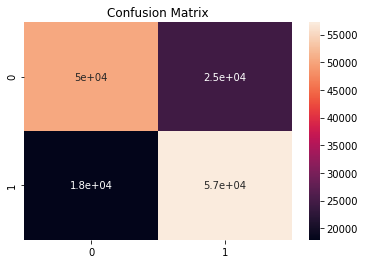

In [11]:
print('The accuracy is:', metrics.accuracy_score(y_test, prediction))
print("\n")
print("Classification Report:")
print(metrics.classification_report(y_test, prediction))

sns.heatmap(confusion_matrix(y_test, prediction), annot=True)
plt.title("Confusion Matrix")
plt.show()